In [43]:
#IMPORTS
import re

import pandas as pd
import numpy as np
import scipy
import matplotlib
matplotlib.use('Qt4Agg')
%matplotlib inline
from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = (18, 8)

import statsmodels.api as sm
import seaborn as sns

/usr/local/lib/python3.4/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [56]:
#CONSTANTS
USER_FEATURES='Userid,followers,friends,num_tweets,account_created_at,fraction_of_tweets_that_are_mentions_and_not_retweets,fraction_of_tweets_that_are_retweets,fraction_of_tweets_containing_pictures,fraction_of_tweets_containing_youtube_videos,fraction_of_tweets_containing_other_urls,fraction_of_tweets_containing_a_hashtag,number_of_distinct_users_mentioned,number_of_distinct_users_retweeted,average_summed_retweet_count_for_this_user_averaged_over_the_total_number_of_tweets_by_this_user,fraction_of_the_users_tweets_that_were_retweeted,average_summed_retweet_count_per_week,average_summed_retweet_count_for_things_that_have_non_zero_retweets,average_summed_retweet_count_per_week_by_num_followers,average_summed_retweet_count_for_things_that_have_non_zero_retweets_by_num_followers,avg_no_of_friends_of_friends,avg_no_of_followers_of_friends,BE,FR,DE,JP,JM,BR,FI,CO,VE,PR,RU,NL,PT,RS,TT,TR,LV,NZ,TH,PH,RO,CA,PL,AE,GR,CL,BH,EG,ZA,IT,AR,AU,GB,IN,IE,ID,ES,KE,SG,NO,US,KR,KW,SA,MY,MX,SE,is_male,is_female,is_father,is_mother,is_student,leaning_democrat,leaning_republican,is_from_city,is_from_rural,categories_count,gaming,comedy,animals,finance,film_animation,science_tech,travel,people_blogs,howto,entertainment,sports,autos,music,scifi,news_politics,nonprofit,education,movies,shows,num_youtube_videos_shared,min_lag_between_time_uploaded_and_time,mean_lag,median_lag,max_lag,std_dev_of_lag,min_num_of_views_for_videos_shared_by_this_user,mean_num_of_views,median_num_of_views,max_num_of_views,std_dev_of_num_of_views,min_num_of_comments,mean_num_of_comments,median_num_of_comments,max_num_of_comments,std_dev_of_num_of_comments,min_polarization_score_of_users_videos,mean_polarization,median_polarization,max_polarization,std_dev_of_polarization_score,vgaming,vcomedy,vanimals,vfinance,vfilm_animation,vscience_tech,vtravel,vpeople_blogs,vhowto,ventertainment,vsports,vtrailers,vautos,vmusic,vscifi,vnews_politics,vnonprofit,veducation,vmovies,vshows,vis_non_promotional'.split(',')
TWEET_INTERESTS='gaming,comedy,animals,finance,film_animation,science_tech,travel,people_blogs,howto,entertainment,sports,autos,music,scifi,news_politics,nonprofit,education,movies,shows'.split(',')
VIDEO_INTERESTS='vgaming,vcomedy,vanimals,vfinance,vfilm_animation,vscience_tech,vtravel,vpeople_blogs,vhowto,ventertainment,vsports,vautos,vmusic,vscifi,vnews_politics,vnonprofit,veducation,vmovies,vshows'.split(',')#trailers omitted to keep same vectors

#plot parameters for enhanced plots
plt.rcParams.update({'axes.titlesize': 22})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'legend.fancybox':True})
plt.rcParams.update({'xtick.labelsize':14})
plt.rcParams.update({'ytick.labelsize':14})

save = True
load = True


In [3]:
#FUNCTIONS

def is_retweet(text):
    regex = r'(RT|via)((?:\b\W*@\w+)+)'
    match = re.search(regex, text)
    if match:
        return True
    return False

def plot_predictions(y_true, y_pred, title=""):
    x = np.arange(y_true.shape[0])
    plt.plot(x, y_true, "bo")
    plt.plot(x, y_true, "b-", label="y_true")

    plt.plot(x, y_pred, "ro")
    plt.plot(x, y_pred, "r-", label="y_predicted")
    plt.legend()
    plt.title(title)
    if(save):
        plt.savefig('../figures/'+title+'.png', format='png', dpi=300)
    

def cosine_dist(u, v):
    return scipy.spatial.distance.cosine(u, v)


def get_content_dist_df(df):
    '''
    @param df: A dataframe containing TWEET_INTERESTS and VIDEO_INTERESTS columns
    for each user
    '''
    content_dist_df = pd.DataFrame(np.zeros(df.shape[0]), columns=['content_dist'])
    
    for i in range(df.shape[0]):
        content_dist_df.ix[i, 'content_dist'] = cosine_dist(df.ix[i,TWEET_INTERESTS].values, 
                                                            df.ix[i, VIDEO_INTERESTS].values)
    
    return content_dist_df


def add_content_dist(data, ufeats):
    '''
    This methods calculates a distance measure between a user's interests and 
    his/her video interests. 
    @param data: A dataframe containing a column 'userid'
    @return: adds "content_dist"  column to the given dataframe 'data'.
    '''
    
    newdat = data.merge(ufeats[['Userid'] + TWEET_INTERESTS + VIDEO_INTERESTS],
                   on='Userid', how='left')
    content_dist_df = get_content_dist_df(newdat[TWEET_INTERESTS+VIDEO_INTERESTS])
    
    return pd.tools.merge.concat([data, content_dist_df], axis=1)
    

def get_Au2v(data, ufeats):
    '''
    This method builds a measure of called Au2v which means the number of times a user's
    tweet is re-tweeted by 
    @param data: a data frame containing "userid" column
    @param ufeats: user features dataframe 
    '''
#     #read followership data
#     followingdat = pd.read_csv('../data/user-followership.txt', delimiter='\t')
#     
#     #read user_tweet_video.txt
#     utweetdat = pd.read_csv('../data/user_tweet_video.txt', delimiter='\t')
#     utweetdat.columns = ['Userid', 'Tweetid', 'Videoid']
#     utweetdat = utweetdat.merge(data, on='Userid', how='right')
# 
#     #read tweet_context.txt
#     tweets = pd.read_csv('../data/tweet-content-final.txt', delimiter='\t', encoding="ISO-8859-1")
#     tweets.columns = ["Tweetid", 'Text']
#     #add is_retweet column to this dataframe
#     tweets['Is_retweet'] = tweets['Text'].apply(lambda tweet: is_retweet(tweet))
    
    newdat = data.merge(ufeats[['Userid', 'fraction_of_the_users_tweets_that_were_retweeted']],
                   on='Userid', how='left')
        
    return newdat['fraction_of_the_users_tweets_that_were_retweeted']
    
    

def get_data():
    '''
    @return: X, y ; where X is a dataframe (Independent Variables:
    score, dscore, content_dist), and
    y is a series, dependent variable, which is the number of times a user's tweet 
    is retweeted by his/her followers. 
    '''
    #read user_all_features.txt for number of retweets for each user
    ufeats = pd.read_csv('../data/user_all_features.txt', delimiter='\t', 
                         header=None)
    ufeats.columns = USER_FEATURES
    
    if(load):
        data = pd.read_csv('../data/data.csv', index_col='index')
    else:
        #read score files
        scoredat = pd.read_csv('../data/userid_score.txt', delimiter='\t')
        dscoredat = pd.read_csv('../data/userid_dscore.txt', delimiter='\t')
        
        #merge both on common userids 
        data = scoredat.merge(dscoredat, on='Twitter_UID', how='inner')
        data = data.rename(columns={"Twitter_UID":"Userid", "D_Score":'Dscore'})
        
        #build content-distance column for each userid
        data = add_content_dist(data, ufeats)
        
        #handle nans
        data = data.dropna()
        data.index = np.arange(data.shape[0]) #re-index
        
        #save data
        data.to_csv('../data/data.csv', index_label='index')
    
    #get dependent variable
    y = get_Au2v(data, ufeats)
    
    #set independent variables
    X = data.drop('Userid', axis=1)

    return X, y 


## Regression Analysis

In [4]:
#get data
X, y = get_data()

In [5]:
y.name = 'Au2v'

Shape i.e. size of the data: 

In [6]:
X.shape

(71952, 3)

X contains three columns, as : 

In [7]:
X.head()

,Score,Dscore,content_dist
index,,,
0,1.445670,0.06979,0.323834
1,4.358922,165.54309,0.067285
2,6.271701,0.32705,0.137112
3,0.118323,0.00910,1.000000
4,3.407387,2.65122,0.513020


####Linear regression on data. 

In [45]:
#Fit a linear model
mod = sm.OLS(endog=y, exog=X).fit()

In [46]:
#print summary
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Au2v   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                 1.570e+04
Date:                Tue, 13 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:22:13   Log-Likelihood:                -8576.9
No. Observations:               71952   AIC:                         1.716e+04
Df Residuals:                   71949   BIC:                         1.719e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Score         5.791e-05   3.78e-06     15.300      0.000      5.05e-05  6.53e-05
Dscore        4.364e-05   4.51e-06      9.667      0.000      3.48e-05  5.25e-05
content_dist     0.3891      0.002    213.060      0.000         0.386     0.393
==============================================================================
Omnibus:                     2091.840   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2323.421
Skew:                           0.408   Prob(JB):                         0.00
Kurtosis:                       3.333   Cond. No.                         746.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above regression summary shows that coeffiecients of all predictors are significant (P>|t| is greater less than 0.05). Therefore, Score, Dscore and content_dist can be considered as good predictors. 

####Regression plots for each independent variable:

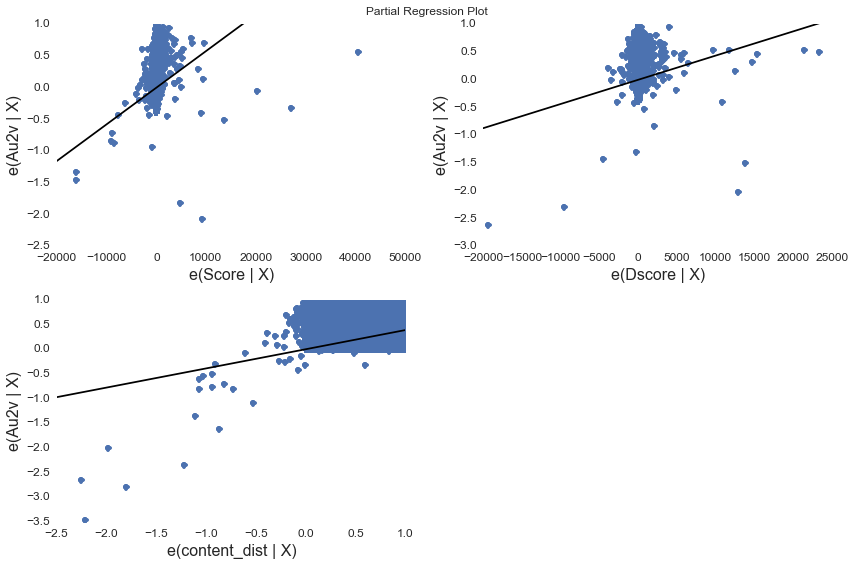

In [47]:
#plot regression plots for each independent variable
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)
if(save):
    plt.savefig('../figures/PartialRegressionPlot.png', format='png', dpi=300)


The above regression plots for each predictor shows the effect of outliers on the estimated regression coefficient. Regression line is pulled out of its optimal tracjectory due these outliers. 

####Regression Plots for individual Predictors

##### 1. Regression  plots for "Score" : 

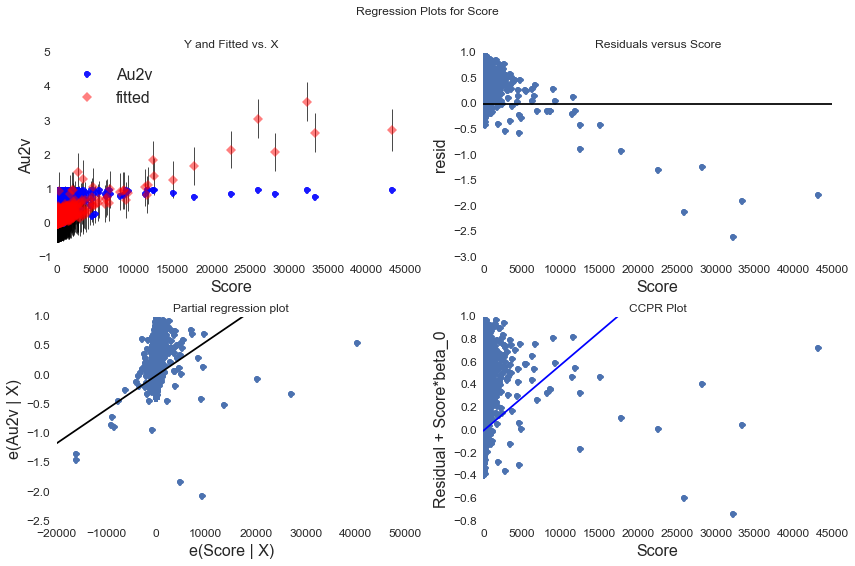

In [48]:
#all regression plots for "Score"
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(mod, "Score", fig=fig)
if(save):
    plt.savefig('../figures/RegressionPlots_Score.png', format='png', dpi=300)

##### 2. Regression  plots for "D_Score" : 

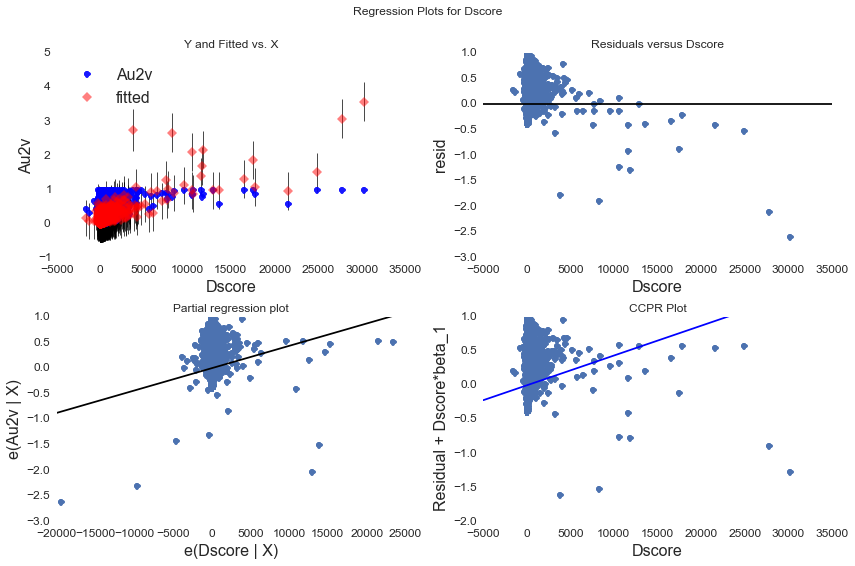

In [50]:
#all regression plots for DScore
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(mod, "Dscore", fig=fig)
if(save):
    plt.savefig('../figures/RegressionPlots_Dscore.png', format='png', dpi=300)

##### 3. Regression plots for cosine distance i.e. "content_dist" : 

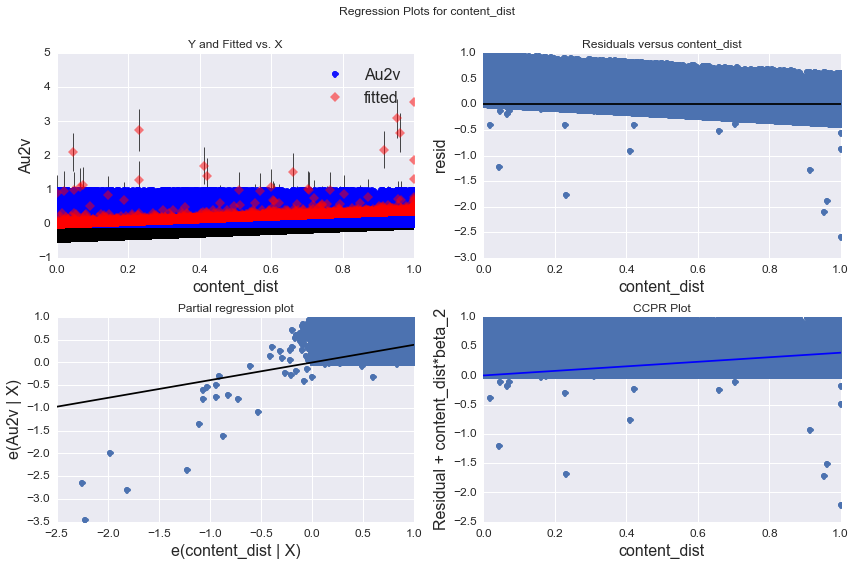

In [13]:
#all regression plots for cosine content_distance
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(mod, "content_dist", fig=fig)
if(save):
    plt.savefig('../figures/RegressionPlots_content_dist.png', format='png', dpi=300)

#### Plot for each Predictors,  depicting  fitted values with confidence interval of predictions: 

The following plots show that fitted values of Au2v and its prediction confidence for each independent variable. These plots show that fitted values are quite close the true values of Au2v except for the outlier points. This suggests that removal of outliers would yield a better estimate. Removal of outliers is explored in later sections. 

##### 1. Fitted values of Au2v Vs Score

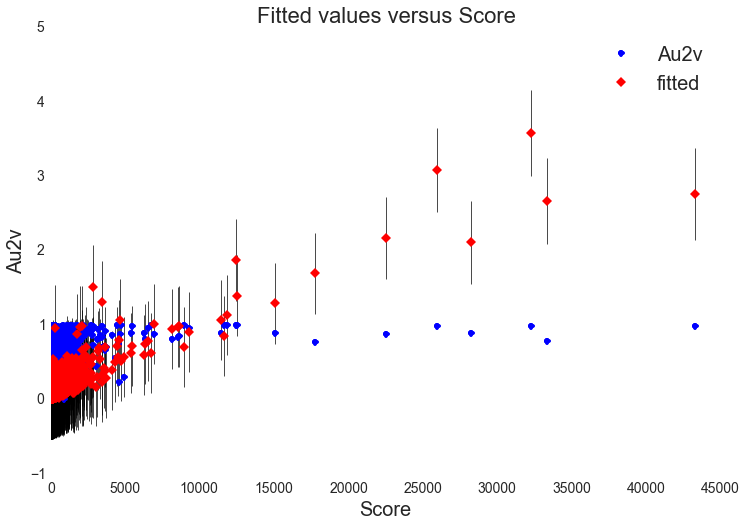

In [57]:
#fitted values with prediction confidence interval, for Score
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(mod, "Score", ax=ax)
if(save):
    plt.savefig('../figures/FittedPlot_Score.png', format='png', dpi=300)

##### 2. Fitted values of Au2v Vs Dscore

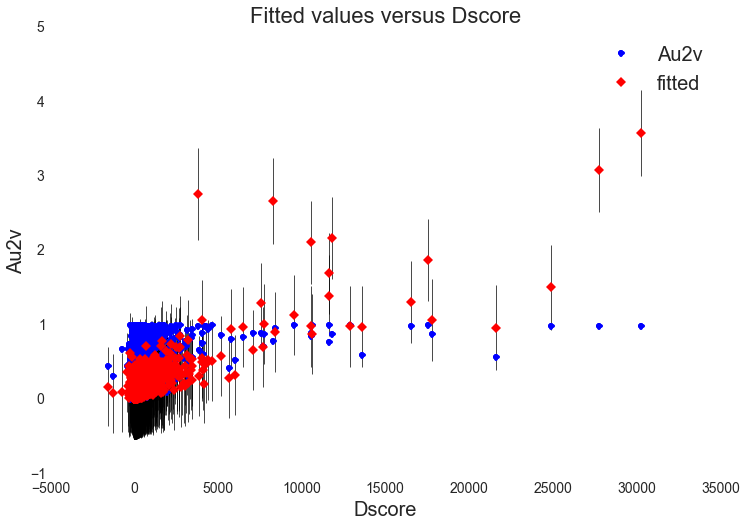

In [58]:
#fitted values with prediction confidence interval, for Dscore
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(mod, "Dscore", ax=ax)
if(save):
    plt.savefig('../figures/fittedPlot_Dscore.png', format='png', dpi=300)

##### 3. Fitted values of Au2v Vs content_dist

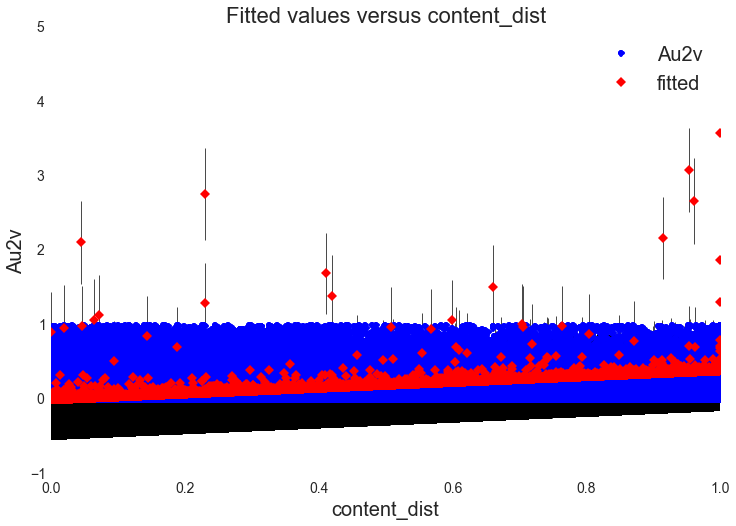

In [59]:
#fitted values with prediction confidence interval, for content_distance
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(mod, "content_dist", ax=ax)
if(save):
    plt.savefig('../figures/fittedPlot_content_dist.png', format='png', dpi=300)

From all above plots it is clear that scale is skewed due to presence of outliers. We should handle these outliers manually or use automated robust linear regression methods for handling outliers. 
In the next section, we experiment on the following: 

1. Robust linear regression for handling outliers
2. Building and including 3rd independent variable "content_distance" into analysis.


### Linear Regression (after removing outliers)

A rough estimate of detecting outliers can be done by using the quantile distributions of each independent variable, as follows:

In [17]:
#distributions for detecting outlier thresholds
X.describe()

,Score,Dscore,content_dist
count,71952.000000,71952.000000,71952.000000
mean,21.227703,15.880803,0.459111
std,349.102908,292.727717,0.315837
min,0.000000,-1610.253490,0.000000
25%,0.787060,0.000140,0.172534
50%,2.562232,0.526050,0.415394
75%,6.902750,2.308805,0.724986
max,43262.678131,30235.027960,1.000000


From the above table, as a guess we could take values of score and dscore only upto 10 and 5  respectively. 

In [18]:
X1 = X[(X['Score'] < 10) & (X['Dscore'] < 5)]
y1 = y[(X['Score'] < 10) & (X['Dscore'] < 5)]

X1.shape

(54473, 3)

####Fit ordinary least squares regression model on data obtained after removing outlier data points:

In [19]:
#Fit a robust linear model
mod = sm.OLS(endog=y1, exog=X1).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Au2v   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 2.442e+04
Date:                Tue, 13 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:06:04   Log-Likelihood:                 10185.
No. Observations:               54473   AIC:                        -2.036e+04
Df Residuals:                   54470   BIC:                        -2.034e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Score            0.0394      0.000    117.275      0.000         0.039     0.040
Dscore           0.0365      0.001     45.284      0.000         0.035     0.038
content_dist     0.1728      0.002     95.400      0.000         0.169     0.176
==============================================================================
Omnibus:                     8209.117   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14676.365
Skew:                           0.978   Prob(JB):                         0.00
Kurtosis:                       4.626   Cond. No.                         7.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above results show considerable improvement w.r.t. R-squared. Also, Durbin-watson statistic close to 2 confirms normality assumption of residuals. Also, all predictor's coefficients are significant as P>|t| is less than 0.05 and hence are good predictors. 

##### Test normality of residuals using qqplot: 

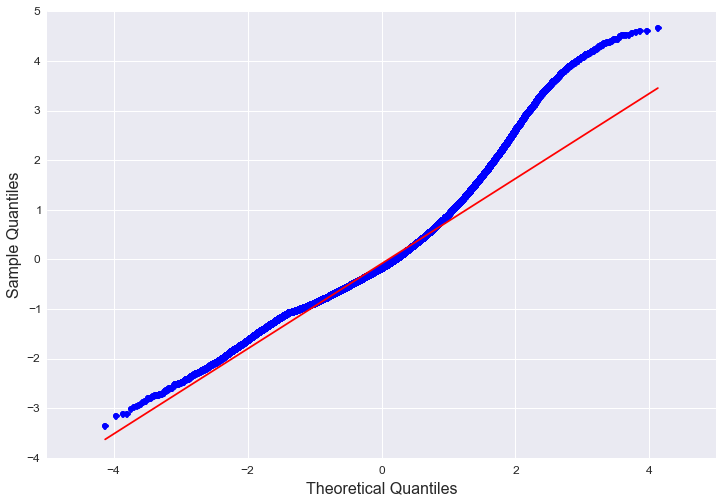

In [20]:
#see qqplot for normality test
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(mod.resid, line='q', ax=ax, fit=True)
if(save):
    plt.savefig('../figures/qqplot.png', format='png', dpi=300)

Above qqplot suggests deviation from normality at higher quantiles. 

####Regression plots for each independent variable:

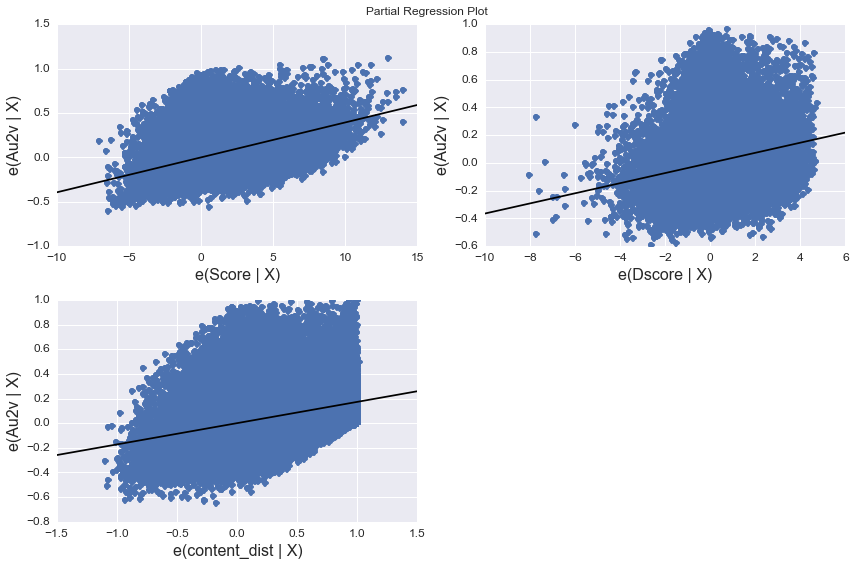

In [21]:
#plot regression plots for each independent variable
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)
if(save):
    plt.savefig('../figures/PartialRegressionPlot(Outliers Removed).png', format='png', dpi=300)

From the above plots it is clear that after removing outliers we get a better fit of regression line on each independent variable. That is, path of regression line is now more aligned to the the optimal path. 

###Predictive Modeling 

In [22]:
#Model
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

rnd = np.random.RandomState(seed=13)
shuffle = False
nfolds = 10

def do_cv(X, y):
    kfcv = KFold(n=X.shape[0], n_folds=nfolds, shuffle=shuffle, random_state=rnd)
    reg_lr = linear_model.LinearRegression(fit_intercept=False, 
                                           normalize=False, 
                                           copy_X=True, 
                                           n_jobs=-1)
    cv_preds = np.zeros(y.shape[0])
    for k, (cv_train, cv_test) in enumerate(kfcv):
        reg_lr.fit(X.iloc[cv_train,:], y.iloc[cv_train])
        ypred = reg_lr.predict(X.iloc[cv_test,:])
        cv_preds[cv_test] = ypred
        rmse_fold = round(np.sqrt(mean_squared_error(y.iloc[cv_test].values, ypred)), 4)
        print("=============================================")
        print("CV Fold "+ str(k) +" RMSE= "+ str(rmse_fold))
    print("#######Total RMSE %s"%(round(np.sqrt(mean_squared_error(y.values, cv_preds)), 4)))
    return cv_preds

CV Fold 0 RMSE= 0.2736
CV Fold 1 RMSE= 0.267
CV Fold 2 RMSE= 0.2773
CV Fold 3 RMSE= 0.2701
CV Fold 4 RMSE= 0.2749
CV Fold 5 RMSE= 0.2728
CV Fold 6 RMSE= 0.2722
CV Fold 7 RMSE= 0.27
CV Fold 8 RMSE= 0.2772
CV Fold 9 RMSE= 0.2729
#######Total RMSE 0.2728


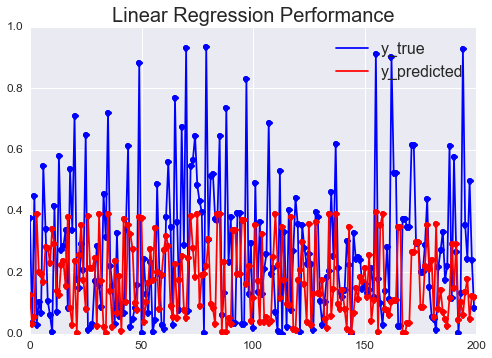

In [23]:
#model using linear regression on score, dscore and content-dist features 
cv_preds = do_cv(X, y)

#plot predictions
plot_predictions(y[:200], cv_preds[:200], title='Linear Regression Performance')

Above, we did a 10 fold cross-validation for predicting Au2v dependent variable from Score, Dscore and content-dist independent variables. The results of the predictive modeling using linear regression above show that we achieve a root mean squared error of 0.2728 (across all folds), which means that our prediction varies by 0.2728 amount from the true value of A2uv. 

CV Fold 0 RMSE= 0.2011
CV Fold 1 RMSE= 0.1964
CV Fold 2 RMSE= 0.2047
CV Fold 3 RMSE= 0.2013
CV Fold 4 RMSE= 0.2
CV Fold 5 RMSE= 0.1999
CV Fold 6 RMSE= 0.1995
CV Fold 7 RMSE= 0.1988
CV Fold 8 RMSE= 0.2034
CV Fold 9 RMSE= 0.202
#######Total RMSE 0.2007


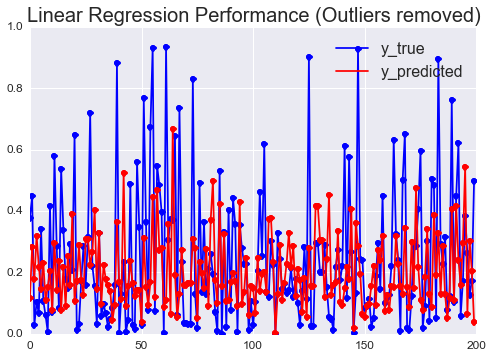

In [24]:
#model using linear regression using score, dscore and content-dist features on outlier filtered data
cv_preds = do_cv(X1, y1)

#plot predictions
plot_predictions(y1[:200], cv_preds[:200], title="Linear Regression Performance (Outliers removed)")

Above, we did a 10 fold cross-validation for predicting Au2v dependent variable from Score, Dscore and content-dist independent variables. This time we did predictive modeling after removing outliers from the data. The results of the predictive modeling using linear regression above show that we achieve a root mean squared error of 0.20 (across all folds), which means that our prediction varies by 0.20 amount from the true value of A2uv. This shows a considerable improvement in prediction error than modeling with original data (with outliers). 

###Classification : Predicting popularity of a user 

If Au2v crosses a threshold, say 0.3, i.e. if more than 30% tweets of user 'u' are retweeted by others users then user 'u' can be considered as a popular user. This can also be interpreted as "if a user u's tweets will be popular or not given user u's DScore, score and content-distance(measure of his tweet's similiarity with his video interests) 

In [25]:
#create binary class target, popular or not popular
thres = 0.25
ybinary_preds = pd.Series(cv_preds)
ybinary_preds[ybinary_preds >= thres] = 1
ybinary_preds[ybinary_preds < thres] = 0

ybinary_true = y1.copy(True)
ybinary_true[y1 >= thres] = 1
ybinary_true[y1 < thres] = 0

#random prediction
yrand = np.random.randint(0, 2, size=y1.shape[0])

In [26]:
#calculate precision and recall metrics on our predictions
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
precision = precision_score(ybinary_true, ybinary_preds)
recall = recall_score(ybinary_true, ybinary_preds)
prand = precision_score(ybinary_true, yrand)
rrand = recall_score(ybinary_true, yrand)

print("Model  ## Precision: %f, Recall: %f"%(precision, recall))
print("Random ## Precision: %f, Recall: %f"%(prand, rrand))


Model  ## Precision: 0.550148, Recall: 0.395276
Random ## Precision: 0.398258, Recall: 0.497970


The above precision and recall of our model shows that precision is much better than random predictions, i.e. our model does learn from the predictors. However, recall is low which suggests the need of additional features/predictors to improve model. 

#### Using Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import GaussianNB

#create binary classification target
yb = y1.copy(True)
yb[y1 >= thres] = 1
yb[y1 < thres] = 0

#do 10 fold cross validation with naive bayes classifier
def do_cv_clf(X, y, clf):
    kfcv = KFold(n=X.shape[0], n_folds=nfolds, shuffle=shuffle, random_state=rnd)    
    cv_preds = np.zeros(y.shape[0])
    for k, (cv_train, cv_test) in enumerate(kfcv):
        clf.fit(X.iloc[cv_train,:], y.iloc[cv_train])
        ypred = clf.predict(X.iloc[cv_test,:])
        cv_preds[cv_test] = ypred
        precisioncv = precision_score(y.iloc[cv_test].values, ypred)
        recallcv = recall_score(y.iloc[cv_test].values, ypred)
        print("=============================================")
        print("CV Fold %d: precision= %f, recall= %f"%(k, precisioncv, recallcv))
        
    print("\n###### Overall Precision %s"%(precision_score(y, cv_preds)))
    print("###### Overall Recall %s"%(recall_score(y, cv_preds)))
    return cv_preds

In [28]:
#create naive bayes classifier and do 10 fold crossvalidation
gnb = GaussianNB()
cv_preds = do_cv_clf(X1, yb, gnb)

CV Fold 0: precision= 0.572289, recall= 0.355972
CV Fold 1: precision= 0.558531, recall= 0.346629
CV Fold 2: precision= 0.597454, recall= 0.340899
CV Fold 3: precision= 0.566616, recall= 0.345633
CV Fold 4: precision= 0.574883, recall= 0.335152
CV Fold 5: precision= 0.556791, recall= 0.334128
CV Fold 6: precision= 0.612585, recall= 0.363636
CV Fold 7: precision= 0.580952, recall= 0.331372
CV Fold 8: precision= 0.628362, recall= 0.349660
CV Fold 9: precision= 0.572763, recall= 0.341057

###### Overall Precision 0.581917381138
###### Overall Recall 0.344436242849


#### Using Random Forest Classifier

In [29]:
#do random forest classification
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, 
                            n_jobs=-1,
                            max_features=None,
                            min_samples_split=2
                           )
cv_preds = do_cv_clf(X1, yb, rf)


CV Fold 0: precision= 0.516624, recall= 0.473068
CV Fold 1: precision= 0.516854, recall= 0.480532
CV Fold 2: precision= 0.563243, recall= 0.472991
CV Fold 3: precision= 0.533720, recall= 0.473143
CV Fold 4: precision= 0.537456, recall= 0.486130
CV Fold 5: precision= 0.512299, recall= 0.456625
CV Fold 6: precision= 0.546788, recall= 0.486499
CV Fold 7: precision= 0.543444, recall= 0.467180
CV Fold 8: precision= 0.547658, recall= 0.461224
CV Fold 9: precision= 0.532749, recall= 0.478684

###### Overall Precision 0.534962484368
###### Overall Recall 0.473657501384


From above two classifiers, we see that for :
1. Naive Bayes classifier, precision is 0.58 (better than linear regression) and recall is 0.34(worse than linear regression)
2. Random Forest Classifier, precision is 0.53(better than baseline but not better than linear regression and naive bayes). While, recall is 0.47 (better than both naive bayes, linear regression and slightly closer to baseline). 

### Experimenting with log transformations

In [30]:
X1.describe()

,Score,Dscore,content_dist
count,54473.000000,54473.000000,54473.000000
mean,2.363554,0.697239,0.473769
std,2.367951,1.103082,0.317740
min,0.000000,-6.465160,0.000000
25%,0.465676,0.000010,0.186532
50%,1.651951,0.312220,0.433473
75%,3.542785,1.045990,0.746077
max,9.999569,4.999690,1.000000


In [60]:
#do log transformation on indpendent variables
X2 = pd.DataFrame()
X2['Score'] = np.log1p(X1['Score'].values)
X2['Dscore'] = X1['Dscore'].values
X2['content_dist'] = np.log1p(X1['content_dist'].values)


In [61]:
X2.describe()

,Score,Dscore,content_dist
count,54473.000000,54473.000000,54473.000000
mean,0.977490,0.697239,0.364495
std,0.690004,1.103082,0.216389
min,0.000000,-6.465160,0.000000
25%,0.382317,0.000010,0.171035
50%,0.975296,0.312220,0.360100
75%,1.513540,1.045990,0.557372
max,2.397856,4.999690,0.693147


#####Training linear regression model on log(1+x) transformed data

In [33]:
#model using linear regression using score, dscore and content-dist features on outlier filtered data
cv_preds_lr = do_cv(X2, y1)

cv_preds_lr_binary = pd.Series(cv_preds_lr)
cv_preds_lr_binary[cv_preds_lr >= thres] = 1
cv_preds_lr_binary[cv_preds_lr < thres] = 0

precision = precision_score(ybinary_true, cv_preds_lr_binary)
recall = recall_score(ybinary_true, cv_preds_lr_binary)
prand = precision_score(ybinary_true, yrand)
rrand = recall_score(ybinary_true, yrand)

print("Model  ## Precision: %f, Recall: %f"%(precision, recall))
print("Random ## Precision: %f, Recall: %f"%(prand, rrand))

CV Fold 0 RMSE= 0.1872
CV Fold 1 RMSE= 0.1841
CV Fold 2 RMSE= 0.1912
CV Fold 3 RMSE= 0.1872
CV Fold 4 RMSE= 0.1869
CV Fold 5 RMSE= 0.1874
CV Fold 6 RMSE= 0.1857
CV Fold 7 RMSE= 0.1851
CV Fold 8 RMSE= 0.19
CV Fold 9 RMSE= 0.1884
#######Total RMSE 0.1873
Model  ## Precision: 0.535617, Recall: 0.527265
Random ## Precision: 0.398258, Recall: 0.497970


The above results show that log(1+x) transformation improves the model's recall. Both Precision and recall are better than the baseline. 


#####Training Random Forest Classifier on log(1+x) transformed data

In [34]:
#train random forest classifier on transformed data
rf = RandomForestClassifier(n_estimators=200, 
                            n_jobs=-1,
                            max_features=None,
                            min_samples_split=2
                           )
cv_preds_rf = do_cv_clf(X2, yb, rf)

CV Fold 0: precision= 0.518941, recall= 0.468384
CV Fold 1: precision= 0.512020, recall= 0.475309
CV Fold 2: precision= 0.558525, recall= 0.474353
CV Fold 3: precision= 0.532730, recall= 0.467539
CV Fold 4: precision= 0.531059, recall= 0.474307
CV Fold 5: precision= 0.517296, recall= 0.463298
CV Fold 6: precision= 0.542843, recall= 0.484698
CV Fold 7: precision= 0.542767, recall= 0.465369
CV Fold 8: precision= 0.545115, recall= 0.463039
CV Fold 9: precision= 0.530021, recall= 0.474513

###### Overall Precision 0.533041027247
###### Overall Recall 0.471120132866


#### Training Naive Bayes classifier on log(1+x) transformed data

In [35]:
gnb = GaussianNB()
cv_preds_nb = do_cv_clf(X2, yb, gnb)

CV Fold 0: precision= 0.566879, recall= 0.416862
CV Fold 1: precision= 0.552598, recall= 0.414055
CV Fold 2: precision= 0.592105, recall= 0.408534
CV Fold 3: precision= 0.552171, recall= 0.397945
CV Fold 4: precision= 0.569180, recall= 0.394725
CV Fold 5: precision= 0.550763, recall= 0.395615
CV Fold 6: precision= 0.592686, recall= 0.423042
CV Fold 7: precision= 0.583279, recall= 0.407424
CV Fold 8: precision= 0.602961, recall= 0.406349
CV Fold 9: precision= 0.564020, recall= 0.408248

###### Overall Precision 0.572568093385
###### Overall Recall 0.407316848127


The above results on naive bayes classifier show that log(1+x) transformation has improved recall from 0.34 to 0.40, precision is slightly decreased. However, recall still remains below the baseline. 

### Comparing precision and recall of various models

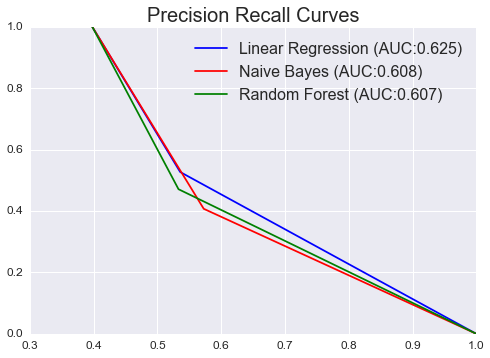

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precisionlr, recalllr, _ = precision_recall_curve(ybinary_true, cv_preds_lr_binary)
auc_lr = average_precision_score(ybinary_true, cv_preds_lr_binary)  

precisionrf, recallrf, _ = precision_recall_curve(ybinary_true, cv_preds_rf)
auc_rf = average_precision_score(ybinary_true, cv_preds_rf)  

precisionnb, recallnb, _ = precision_recall_curve(ybinary_true, cv_preds_nb)
auc_nb = average_precision_score(ybinary_true, cv_preds_nb)  

plt.plot(precisionlr, recalllr, '-b', label='Linear Regression (AUC:%0.3f)'%auc_lr)
plt.plot(precisionnb, recallnb, '-r', label='Naive Bayes (AUC:%0.3f)'%auc_nb)
plt.plot(precisionrf, recallrf, '-g', label='Random Forest (AUC:%0.3f)'%auc_rf)

plt.title("Precision Recall Curves")
plt.legend()
plt.savefig('../figures/precision_recall_curves.png', format='png', dpi=1200)

The above precision-recall curves shows a comparision of performances for Linear Regression, Naive Bayes and Random Forest methods. Higher Area under this curve (AUC) represents better performance, with AUC=1 being the highest achievable performance by a classifier. Above plot shows that Linear Regression has the highest AUC of 0.625. 

### Linear Regression and Plots with log(1+x) transformations

In [62]:
#Fit a robust linear model
y2 = y1.copy(True); y2.index = np.arange(y2.shape[0])
mod = sm.OLS(endog=y2, exog=X2).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Au2v   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                 3.072e+04
Date:                Tue, 13 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:32:54   Log-Likelihood:                 13947.
No. Observations:               54473   AIC:                        -2.789e+04
Df Residuals:                   54470   BIC:                        -2.786e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Score            0.1460      0.001    145.244      0.000         0.144     0.148
Dscore           0.0200      0.001     25.819      0.000         0.018     0.022
content_dist     0.1656      0.003     65.690      0.000         0.161     0.171
==============================================================================
Omnibus:                    10848.216   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22428.486
Skew:                           1.183   Prob(JB):                         0.00
Kurtosis:                       5.070   Cond. No.                         5.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### High Resolution plots

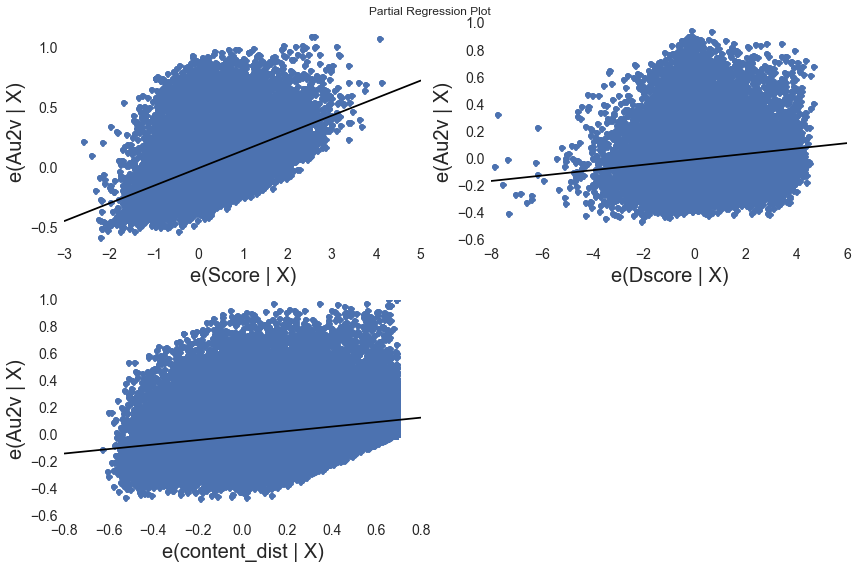

In [63]:
#plot regression plots for each independent variable
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)
if(save):
    plt.savefig('../figures/PartialRegressionPlot(Outliers Removed, log1p).png', format='png', dpi=300)

In [64]:
#fitted values with prediction confidence interval, for Score
indx = np.random.randint(0, y2.shape[0], 100)
mod1 = sm.OLS(endog=y2[indx], exog=X2.ix[indx,:]).fit()

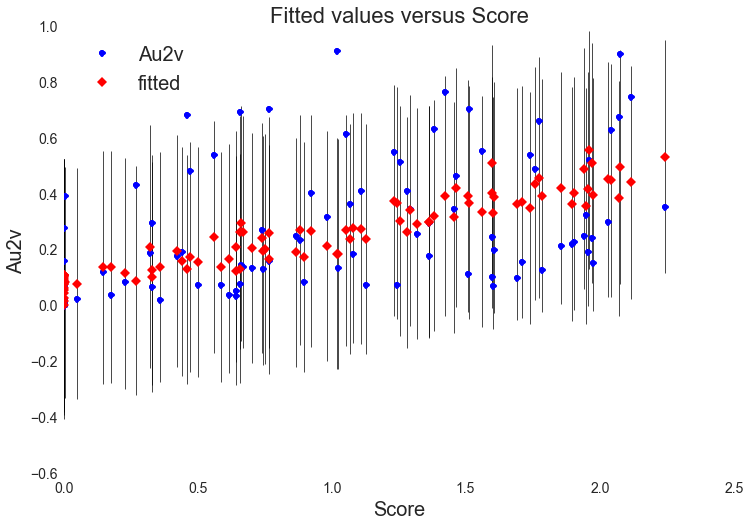

In [66]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(mod1, "Score", ax=ax)
fig.savefig('../figures/log1p(Score)_fitted.png', format='png', dpi=1200)

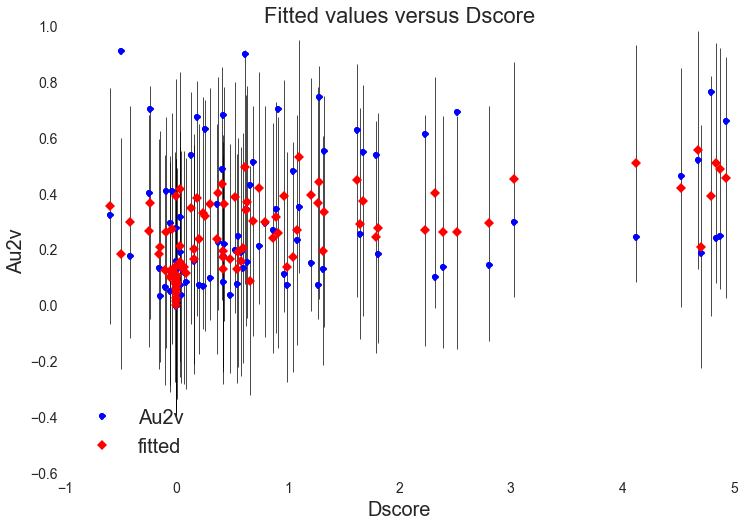

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(mod1, "Dscore", ax=ax)
fig.savefig('../figures/Dscore_fitted.png', format='png', dpi=1200)

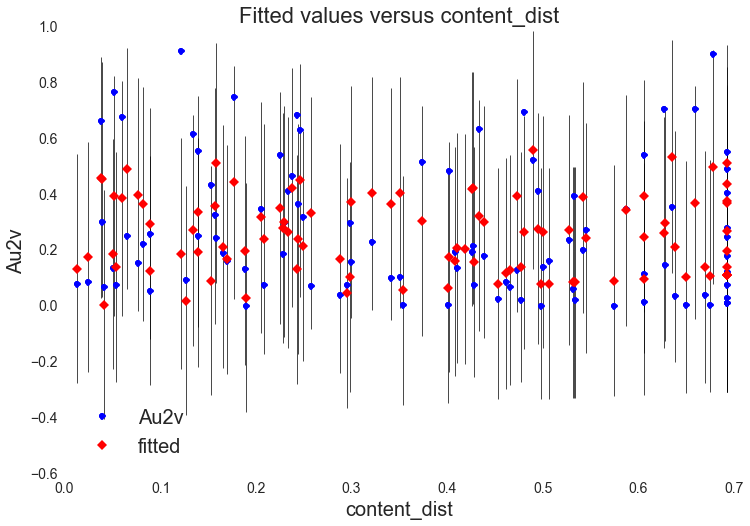

In [68]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(mod1, "content_dist", ax=ax)
fig.savefig('../figures/log1p(content_dist)_fitted.png', format='png', dpi=1200)